In [1]:
import pandas as pd
import textgrid
from data.arctic.extractor import get_phone_fragments

/media/maxim/5d25e004-74c4-4174-8cd3-d5dce3ff6981/maxim/python_projects/speech_recognition/venv_3.8/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Data Loading

In [2]:
arctic_df = pd.read_csv('./data/arctic/arctic_description.csv')

In [3]:

label_frequency = dict()
for _, row in arctic_df.iterrows():
    try:
        labels = textgrid.TextGrid.fromFile(row['annotation_file_path'])
        for interval in labels[1]:
            if interval.mark in label_frequency:
                label_frequency[interval.mark] += 1
            else:
                label_frequency[interval.mark] = 1
    except ValueError as err:
        print(row['annotation_file_path'], err)

label_frequency = {key: value for key, value in sorted(label_frequency.items(), key=lambda item: item[1], reverse=True)}
label_frequency



/media/maxim/Programming/voice_datasets/arctic/l2arctic_release_v5.0/data/YDCK/annotation/arctic_a0272.TextGrid 2.22363
/media/maxim/Programming/voice_datasets/arctic/l2arctic_release_v5.0/data/YDCK/annotation/arctic_a0209.TextGrid 3.55456


{'sp': 8031,
 'N': 6889,
 'AH0': 6663,
 'T': 6067,
 'S': 4477,
 'D': 4422,
 'L': 4037,
 'sil': 3968,
 'R': 3880,
 '': 3635,
 'M': 3485,
 'IH1': 3297,
 'HH': 3195,
 'AH1': 3120,
 'W': 3078,
 'IH0': 3061,
 'K': 2878,
 'AE1': 2768,
 'EH1': 2667,
 'IY1': 2603,
 'F': 2525,
 'IY0': 2061,
 'P': 1962,
 'Z': 1942,
 'AY1': 1916,
 'B': 1892,
 'V': 1870,
 'EY1': 1869,
 'UW1': 1792,
 'ER0': 1760,
 'DH': 1678,
 'AO1': 1634,
 'SH': 1266,
 'NG': 1221,
 'OW1': 1108,
 'AA1': 1095,
 'G': 1046,
 'Y': 947,
 'CH': 787,
 'DH,D,s ': 742,
 'AW1': 713,
 'DH,D,s': 703,
 'Z,S,s': 689,
 'Z,S,s ': 578,
 'UH1': 567,
 'TH': 496,
 'ER1': 490,
 'JH': 422,
 'Z, S, s': 417,
 'IH1,IY1,s ': 375,
 'D,sil,d': 367,
 'R,sil,d': 325,
 'T,sil,d': 281,
 'D, sil, d': 275,
 'T, sil, d': 244,
 'OW1, AO, s': 244,
 'IH1,IY1,s': 238,
 'L,W,s': 223,
 'DH, D, s': 221,
 'OW0': 216,
 'L,sil,d': 211,
 'R,R*,s': 209,
 'OY1': 189,
 'UW0': 178,
 'EY1, EH, s': 177,
 'sil,AH0,a': 174,
 'D,T,s': 166,
 'P,B,s': 162,
 'Z,sil,d': 153,
 'N,NG,s ': 15

In [4]:
def merge_dictionaries(first: dict, second: dict) -> dict:
    for key, value in second.items():
        if key in first:
            first[key].extend(second[key])
        else:
            first[key] = second[key]
    return first

In [5]:
data = dict()
for index, row in arctic_df.iterrows():
    try:
        raw = get_phone_fragments(
            audio_file_path=row['wav_file_path'],
            annotation_file_path=row['annotation_file_path'],
            arpabet_phone_code=['AH0', 'AH1', 'IH0', 'IH1']
        )
        data = merge_dictionaries(data, raw)
    except ValueError as err:
        print(err)


2.22363
3.55456


In [6]:
len(data['AH0'])

6663

## Train-Test splitting

In [7]:
import random
from sklearn.model_selection import train_test_split

In [8]:
ah_utterances = random.sample(data['AH0'], 100)
ah_utterances.extend(random.sample(data['AH1'], 100))
ah_train, ah_test = train_test_split(ah_utterances, test_size=0.2, random_state=42)

In [9]:
ih_utterances = random.sample(data['IH0'], 100)
ih_utterances.extend(random.sample(data['IH1'], 100))
ih_train, ih_test = train_test_split(ih_utterances, test_size=0.2, random_state=42)

## Feature Extraction

In [10]:
%matplotlib inline

import numpy as np
import librosa
import itertools
import librosa.display
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from IPython.display import Audio
from librosa.feature import mfcc

sample_rate = 44100

In [11]:
def unpack_raw_in_float32(in_data: bytes) -> np.ndarray:
    max_int16_value = 2 ** 15
    data = np.frombuffer(in_data, np.int16)
    return data.astype(np.float32) / max_int16_value


def get_mfcc(in_data: np.float32, freq_rate: int, n_fft: int, n_mfcc: int, n_mel: int) -> np.ndarray:
    return mfcc(y=in_data, sr=freq_rate, n_mfcc=n_mfcc, n_fft=n_fft, n_mels=n_mel)


def get_deltas(in_data: np.ndarray, width: int) -> tuple:
    deltas = librosa.feature.delta(in_data, width=width, order=2)
    double_deltas = librosa.feature.delta(deltas, width=width, order=2)
    return deltas, double_deltas


def pack_data(mfccs: np.ndarray, deltas: np.ndarray, double_deltas: np.ndarray) -> np.ndarray:
    return np.hstack((mfccs, deltas, double_deltas))


In [12]:
def feature_extractor(raw_audio: bytes) -> np.ndarray:
    unpacked = unpack_raw_in_float32(raw_audio)
    mfcc_s = get_mfcc(unpacked, freq_rate=sample_rate, n_fft=1024, n_mfcc=5, n_mel=30)
    mfcc_s = np.swapaxes(mfcc_s, 0, 1)
    deltas = get_deltas(mfcc_s, 3)
    return pack_data(mfcc_s, *deltas)


def feature_collector(dataset: list) -> np.ndarray:
    features = np.asarray(())
    for raw_audio in dataset:
        feature_vector = feature_extractor(raw_audio)
        if features.size == 0:
            features = feature_vector
        else:
            features = np.vstack((features, feature_vector))

    return features


In [13]:
ah_features = feature_collector(ah_train)
ih_features = feature_collector(ih_train)

## Hyper parameters tuning

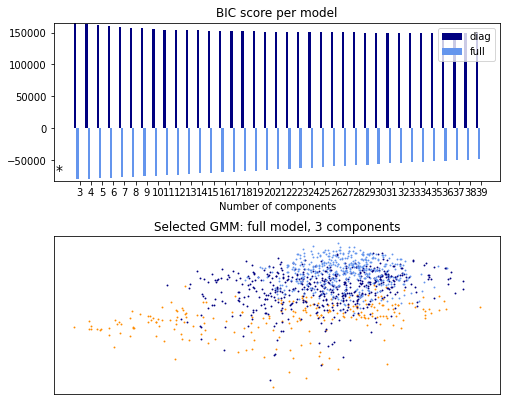

In [44]:
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

lowest_bic = np.infty
bic = list()
n_components_range = range(3, 40)
cv_types = ["diag", "full"]
X = ah_features
for cv_type in cv_types:
    for n_components in n_components_range:
        try:
            # Fit a Gaussian mixture with EM
            gmm = GaussianMixture(
                n_components=n_components, covariance_type=cv_type
            )
            gmm.fit(ah_features)
            bic.append(gmm.bic(ah_features))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

        except ValueError as err:
            print(cv_type, n_components)

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [45]:
ih_gmm = GaussianMixture(n_components=3, max_iter=200, covariance_type='full', n_init=3)
ah_gmm = GaussianMixture(n_components=3, max_iter=200, covariance_type='full', n_init=3)

In [46]:
ah_gmm.fit(ah_features)
ih_gmm.fit(ih_features)

GaussianMixture(max_iter=200, n_components=3, n_init=3)

In [47]:
def recognize_phone(feature_vector: np.ndarray):
    is_ah_scores = np.array(ah_gmm.score(feature_vector))
    is_ah_log_likelihood = is_ah_scores.sum()

    is_ih_scores = np.array(ih_gmm.score(feature_vector))
    is_ih_log_likelihood = is_ih_scores.sum()
    if round(is_ah_log_likelihood, 3) > round(is_ih_log_likelihood, 3):
        return True
    else:
        return False


In [49]:
ih = 0
ah = 0
for test_audio in ih_test:
    vector = feature_extractor(test_audio)
    if recognize_phone(vector):
        ah += 1
    else:
        ih += 1
print(f'IH: {(ih / len(ah_test))}')
print(f'AH: {(ah / len(ah_test))}')

IH: 0.9
AH: 0.1


In [ ]:
waveform = data['IH0'][0]
waveform = unpack_raw_in_float32(waveform)

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(waveform, sample_rate)

In [ ]:
Audio(waveform, rate=sample_rate)

In [ ]:
waveform.shape

In [ ]:
# coeff = get_mfcc(waveform[:1024], sample_rate, 13, n_fft=525)
#coeff = get_mfcc(waveform[:1024], sample_rate, 512, 13)
coeff = mfcc(y=waveform[:1024], sr=sample_rate, n_fft=1024, n_mfcc=13, n_mels=30, center=False)
coeff